In [2]:
from scipy import *
from numpy import *
from matplotlib import *
from matplotlib.pyplot import *
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import numpy.fft as fft
from itertools import product
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
rc('text', usetex=True)
rc('font', family='serif',size='24')
N = 400
dx, dy = 0.05, 0.05
L = N*dx  # /2
x1 = np.linspace(-L/2, L/2, N)
y1 = np.linspace(-L/2, L/2, N)
x = np.array([x1])
y = np.array([y1])
X,Y = meshgrid(x1,y1)
#dx = x[1] - x[0]
#dy = y[1] - y[0]
kx1 = fft.fftfreq(N, dx)*2.0*pi
kx = np.array([kx1])
ky1 = fft.fftfreq(N, dy)*2.0*pi
ky = np.array([ky1])
K = np.sqrt(kx**2 + (ky.T)**2)
K2 = K*K
K2_inv = 1.0/K2
K2 = np.nan_to_num(K2, nan=0, posinf=0, neginf=0)


In [654]:
kfile = open("K2_py.txt", "w")
#K2_re = reshape(K2, (N, N)) 
for i in K2:
    np.savetxt(kfile, i)
kfile.close()

<ipython-input-4-ef55d2e8e502>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, transpose(psi2))


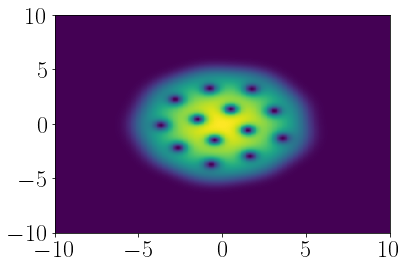

In [4]:
psi_r, psi_c = loadtxt('/Users/kishor/melting/draft/fig3/p7/fort.1',
                       usecols=(0, 1), unpack='True')

psi = reshape(psi_r, (N, N)) + 1j*reshape(psi_c, (N, N))
#psi[psi==0]=1.0e-14+1j*1.0e-14
psi2 = abs(psi)*abs(psi)
angle = np.arctan2(imag(psi), real(psi))
plt.pcolormesh(X, Y, transpose(psi2))

In [5]:
def gradient(psi,kx,ky):
    phi = fft.fft2(psi)
    cpx = fft.ifft2(1j*kx*phi)
    cpy = fft.ifft2(1j*(ky.T)*(phi))
    return cpx, cpy

def current(psi, kx, ky):
    cpx, cpy = gradient(psi,kx,ky)
    jx = imag(conj(psi)*cpx)
    jy = imag(conj(psi)*cpy)
    return jx, jy

def velocity(psi, Omega, x, y, kx, ky):
    rho = abs(psi)*abs(psi)
    cpx, cpy = gradient(psi,kx,ky)
    vx = ((imag(conj(psi)*cpx))/rho) - Omega*y.T # lab frame 
    vx = np.nan_to_num(vx, nan=0, posinf=0, neginf=0)
    vy = ((imag(conj(psi)*cpy))/rho) + Omega*x   # lab frame 
    vy = np.nan_to_num(vy, nan=0, posinf=0, neginf=0)
    return vx, vy

def helmholtz(wx, wy, kx, ky, K2):
    wxk = fft.fft2(wx)
    wyk = fft.fft2(wy)
    kdotw = kx*wxk + (ky.T)*wyk
    wxkc = kdotw*kx/K2  #; wxkc[1] = 0
    wxkc = np.nan_to_num(wxkc, nan=0, posinf=0, neginf=0)
    wykc = kdotw*ky.T/K2 #; wykc[1] = 0
    wykc = np.nan_to_num(wykc, nan=0, posinf=0, neginf=0)
    wxki = wxk - wxkc
    wyki = wyk - wykc
    wxc = fft.ifft2(wxkc)
    wyc = fft.ifft2(wykc)
    wxi = fft.ifft2(wxki)
    wyi = fft.ifft2(wyki)
    Wi = (wxi, wyi)  
    Wc = (wxc, wyc)  
    return Wi, Wc

def energydecomp(psi, Omega, x, y, kx, ky, K2):
    rho = abs(psi)*abs(psi)
    vx, vy = velocity(psi, Omega, x, y, kx, ky)
    wx = np.sqrt(rho)*vx
    wy = np.sqrt(rho)*vy
    Wi, Wc = helmholtz(wx, wy, kx, ky, K2)
    wxi, wyi = Wi
    wxc, wyc = Wc
    et = (abs(wx)*abs(wx) + abs(wy)*abs(wy))
    et *= 0.5
    ei = (abs(wxi)*abs(wxi) + abs(wyi)*abs(wyi))
    ei *= 0.5
    ec = (abs(wxc)*abs(wxc) + abs(wyc)*abs(wyc))
    ec *= 0.5
    return et, ei, ec

In [6]:
def mask1(h, w, c=None, rad=None):  #c-center
    if c is None: 
        c = (int(w/2), int(h/2))
    if rad is None:
        rad = min(c[0], c[1], w-c[0], h-c[1])
    y, x = np.ogrid[:h, :w]
    dis_cen = np.sqrt((x - c[0])**2 + (y-c[1])**2)
    mask = dis_cen <= rad
    return mask

In [7]:
Omega = 0.7
et, ei, ec = energydecomp(psi, Omega, x, y, kx, ky, K2)

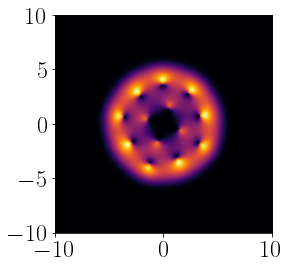

In [8]:
plt.imshow(abs(ei), cmap='inferno', extent=[-10,10,-10,10])

In [9]:
vx, vy = velocity(psi, Omega, x, y, kx, ky)
rho = abs(psi)*abs(psi)
wx = np.sqrt(rho)*vx
wy = np.sqrt(rho)*vy
Wi, Wc = helmholtz(wx, wy, kx, ky, K2)
wxi, wyi = Wi

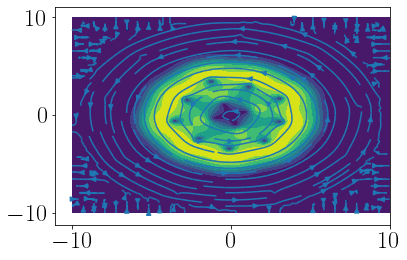

In [23]:
w =np.sqrt(abs(wx)**2 + abs(wy)**2)
#plt.pcolormesh(X, Y, w)
#imshow(w, cmap='inferno')
plt.contourf(x1, y1, np.sqrt(wx**2+wy**2))
plt.streamplot(x1, y1, real(wx), real(wy))

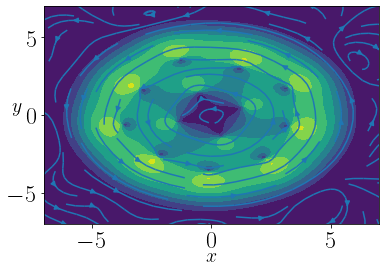

In [1332]:
figsize=(5,5)
f1 = plt.contourf(x1, y1, np.sqrt(wxi**2+wyi**2))
f1 = plt.streamplot(x1, y1, real(wxi), real(wyi))
#plt.axis('equal')
xlabel("$x$", labelpad=-5, fontsize=20)
ylabel("$y$", labelpad=-10,fontsize=20, rotation=360)
xlim(-7,7)
ylim(-7,7)
plt.savefig('vi.png', dpi=400)

In [1286]:
wxf = fft.fft2(wxi); swxf = fft.fftshift(wxf)
wyf = fft.fft2(wyi); swyf = fft.fftshift(wyf)
kx1 = fft.fftshift(kx1)
ky1 = fft.fftshift(ky1)
#kx2 = fft.fftshift(kx1)
#ky2 = fft.fftshift(ky1)

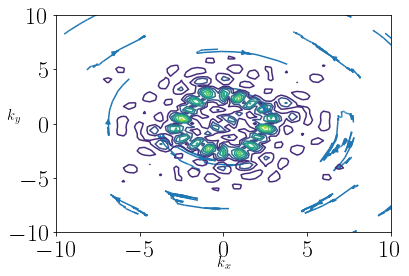

In [1334]:
plt.streamplot(kx1, ky1, real(swxf), real(swyf))
plt.contour(kx1, ky1, sqrt(real(swxf)**2+real(swyf)**2))
xlabel("$k_x$", labelpad=-5, fontsize=15)
ylabel("$k_y$", labelpad=-5,fontsize=15, rotation=360)
xlim(-10,10)
ylim(-10,10)
plt.savefig('vik.png', dpi=400)

In [1366]:
xi = 0.37
kxi = 2*np.pi/(10*xi)
#m1 = np.array([K2, real(swxf)])
#m2 = np.array([K2, real(swyf)])
#mx = np.ma.masked_where(( (abs(K2) >= kxi)&(K2<=-kxi)), real(swxf)) 
#my = np.ma.masked_where(( (abs(K2) >= kxi)&(K2<=-kxi)), real(swyf)) 
#mx = np.ma.masked_where((K2 >= kxi), real(swxf)) 
#my = np.ma.masked_where((K2 >= kxi), real(swyf)) 
# 
h, w = swxf.shape[:2]
m1 = mask1(h, w, c=None, rad=8)
mx = np.multiply(swxf,m1)
my = np.multiply(swyf,m1)
print(shape(mx))

(400, 400)


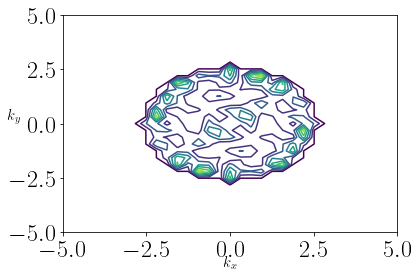

In [1367]:
plt.streamplot(kx1, ky1, real(mx), real(my))
plt.contour(kx1, ky1, sqrt(mx**2+my**2))
xlabel("$k_x$", labelpad=-5, fontsize=15)
ylabel("$k_y$", labelpad=-5,fontsize=15, rotation=360)
plt.axvline(2*pi/(2*xi), color='r', linestyle='-',linewidth=2.) 
#plt.axvline(-2*pi/(4*0.2), color='r', linestyle='-',linewidth=2.)#
xlim(-5,5)
ylim(-5,5)
plt.savefig('vik_masked.png', dpi=400)

In [1364]:
iwx = fft.ifft2(mx)
iwy = fft.ifft2(my)

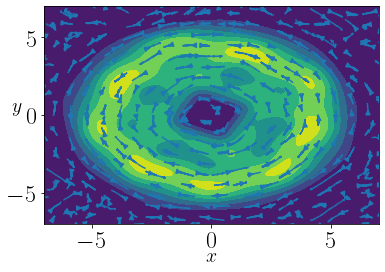

In [1368]:
plt.contourf(x1, y1,  np.sqrt(real(iwx)**2+real(iwy)**2))
plt.streamplot(x1, y1, real(iwx), real(iwy))
#plt.axis('equal')
xlabel("$x$", labelpad=-5, fontsize=20)
ylabel("$y$", labelpad=-10,fontsize=20, rotation=360)
xlim(-7, 7)
ylim(-7,7)
plt.savefig('vi_masked.png', dpi=400)

In [1339]:
vi =np.sqrt(abs(iwx)**2 + abs(iwy)**2)
print(sum(vi)*dx*dy)

50.62743044074952


<ipython-input-1305-79f8b0a1abe1>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, vi)


(-7.0, 7.0)

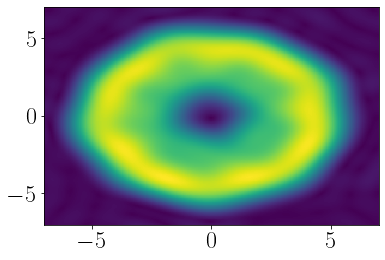

In [1305]:
plt.pcolormesh(X, Y, vi)
xlim(-7, 7)
ylim(-7,7)

In [918]:
#proper mask
#np.savetxt('/Users/kishor/swxf.txt', real(swxf))
#xi = 0.2
#kxi = 2*np.pi/(5*xi)
#wx1 = swxf[:,0]
#wx2 = swxf[:,1]
#mx = np.ma.masked_where(K2<=kxi, real(wxf)) 
#my = np.ma.masked_where(K2<=kxi, real(wyf)) 
#mx1 = np.ma.masked_where(kx <= kxi, [wx2])
#mswx = np.vstack(([mx], [mx1]))
#rm = reshape(mswx,(400,400))
#h, w = wxf.shape[:2]
#m1= mask1(h, w, c=None, rad=20)
#wxf_m = np.multiply(wxf,m1)
#wyf_m = np.multiply(wyf,m1)
#swxf_m = fft.fftshift(wxf_m)
#swyf_m = fft.fftshift(wyf_m)
#plt.streamplot(kx1, ky1, real(wxf_m), real(wyf_m))
#plt.contourf(kx1, ky1,sqrt(swxf_m**2+swyf_m))
#xlabel("$k_x$", labelpad=-5, fontsize=20)
#ylabel("$k_y$", labelpad=-5,fontsize=20, rotation=360)
#xlim(-15,15)
#ylim(-15,15)
#plt.savefig('vik_cut.png', dpi=400)

In [926]:
#np.savetxt('/Users/kishor/swxf.txt', np.c_[K2, real(swxf)])
#np.savetxt('/Users/kishor/swyf.txt', np.c_[K2, real(swyf)])

In [932]:
#mx1 = loadtxt('/Users/kishor/swx_new.txt',usecols=(0), unpack='True')
#my1 = loadtxt('/Users/kishor/swy_new.txt',usecols=(0), unpack='True')
#mx11 = reshape(mx1, (N, N)) 
#my11 = reshape(my1, (N, N)) 
#print(shape(mx11))

(400, 400)


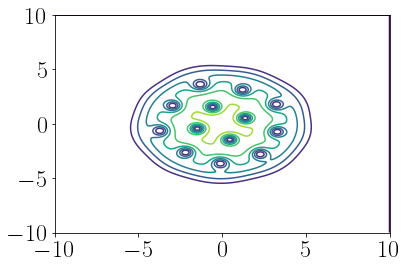

In [26]:
#streamplot(x1, y1, vx, vy, density=1)
contour(x1, y1, abs(psi)**2)

In [1311]:
vxf = fft.fft2(vx) ; svxf = fft.fftshift(vxf)
vyf = fft.fft2(vy); svyf = fft.fftshift(vyf)

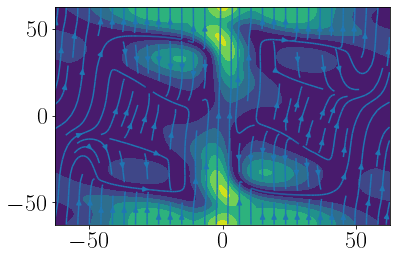

In [1313]:
plt.streamplot(kx1, ky1, real(svxf), real(svyf))
plt.contourf(kx1, ky1, sqrt(real(svxf)**2+real(svyf)**2))
#plt.contour(kx1, ky1, abs(scpf))

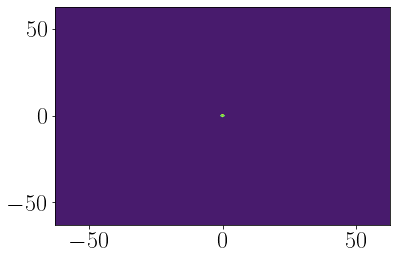

In [1323]:
h, w = svxf.shape[:2]
m1= mask1(h, w, c=None, rad=2)
vxf_m = np.multiply(vxf,m1)
vyf_m = np.multiply(vyf,m1)
plt.streamplot(kx1, ky1, real(vxf_m), real(vyf_m))
plt.contourf(kx1, ky1,sqrt(vxf_m**2+vyf_m))

In [1328]:
vx_m = fft.ifft2(svxf)#; vx_s = fft.ifftshift(vx_m)
vy_m = fft.ifft2(svyf)#; vy_s = fft.ifftshift(vy_m)

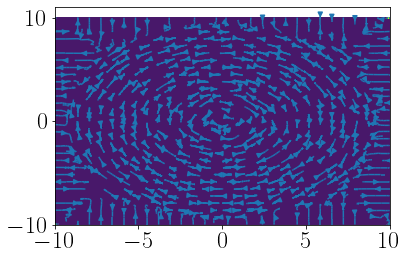

In [1329]:
plt.streamplot(x1, y1, real(vx_m), real(vy_m))
plt.contourf(x1, y1,sqrt(real(vx_m)**2+real(vy_m)**2))